# 5.4 시계열 분석

### 시계열 데이터를 구성하는 주 요소
   - 원계열 : 추세, 계절성, 싸이클, 잔차로 구성
   - 추세 : 시간의 흐름에 따라 점진적인 변화를 관찰
   - 계절성 : 계절에 따른 규칙적인 패턴을 확인
   
### 시계열의 대표 통계 모델
   - 자기회귀(AR), 이동평균(MA), 이동평균을 누적한 자가회귀모델 ARIM이 존재
   
### 시계열 분석 순서
   - 원계열 확인 --> 추세&계절성 분리 --> 잔차 확인 --> 모델선택 --> 결과 공유

In [1]:
# 필요 라이브러리 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller # ADF는 정상성 검정을 위해 사용
from statsmodels.tsa.seasonal import seasonal_decompose # 시계열 데이터 요소 분해
from statsmodels.tsa.arima.model import ARIMA # ARIMA 모델, SARIMA 모델

import pmdarima as pm # auto arima

## 정상성 vs 비정상성
##### 정상성 : 정상성을 띄는 시계열은 해당 시계열이 관측된 시간과 무관 (즉, 시간에 따라 상승하거나 주기적 변화가 있는 추세나 계절성이 없음)
##### 특징
   - 정상 시계열은 평균이 일정
   - 분산이 시점에 의존하지 않음
   - 공분산 또한 시점에 의존하지 않음(시차에는 의존)
   - 정상성을 띄는 시계열은 장기적으로 예측 불가능한 시계열
      - ex) e.g 백색 잡음 white nois가 대표적인 예
   

##### 비정상성 : 시간에 영향을 받는 시계열 (추세나 계절성이 있는 것이 대표적인 특징)
##### 특징
   - 시간의 흐름에 따라 시계열의 평균 수준이 다름
   - 시간의 흐름에 따라 추세를 가짐
   - 시간의 흐름에 따라 계절성이 있음
   - 시간의 흐름에 따라 시계열의 분산이 증가하거나 감소함
   - ex) 여름에 아이스크림 판매량이 높으며, 겨울에 판매량이 낮다(계절성)



## 정상 시계열 - 백색 잡음 (white noise)

In [7]:
# 정규분포에서 난수 365개 추출
np.random.seed(1)

x = np.random.randn(365)

#### 원계열 시도표(Time plot)

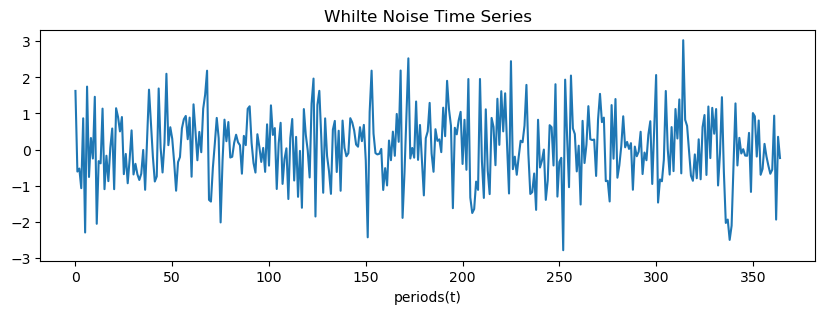

In [8]:
# 백색 잡은 시도표
plt.figure(figsize=(10, 3))

plt.plot(np.arange(365), x)
plt.title('Whilte Noise Time Series')
plt.xlabel('periods(t)')
plt.show()

   - 백색 잡음의 형태 파악
   - 분산이 시간에 따라 커지거나 작아지지 않고 일정한 편이다.

#### Augmented Dickey Fuller Test 단위근 검정(ADF test)
##### Augmented Dickey Fuller Test 가설 검정
$H_0$ : 정상성이 있는 시계열이 아님(단위근)

$H_1$ : 정상성이 있는 시계열
##### 귀무 가설을 기각해야 정상성이 있는 시계열

- 엄밀히 말하면 ADF 가설 검정은
- $H_0$ : $θ=0$ vs $H_1 : θ<0$
- 수식 : $\Delta y_t = α + θy_{t-1} + y_1 \Delta y_{t-1} + ... + y_p \Delta y_{t-p} + \varepsilon_t$


In [9]:
# Aunment Dickey Fuller Test (adfuller)
result = adfuller(x)

In [10]:
result

(-19.772523202104036,
 0.0,
 0,
 364,
 {'1%': -3.4484434475193777,
  '5%': -2.869513170510808,
  '10%': -2.571017574266393},
 952.9340604979548)

In [14]:
print('ADF stat : {:.4f}'.format(result[0]))
print('p_value : {:.4f}'.format(result[1]))
print('Critical Values : ')
for key, value in result[4].items():
    print('\t{} : {:.4f}'.format(key, value))

ADF stat : -19.7725
p_value : 0.0000
Critical Values : 
	1% : -3.4484
	5% : -2.8695
	10% : -2.5710


p_value가 0에 가까움으로 귀무가설 기각 --> 정상 시계열

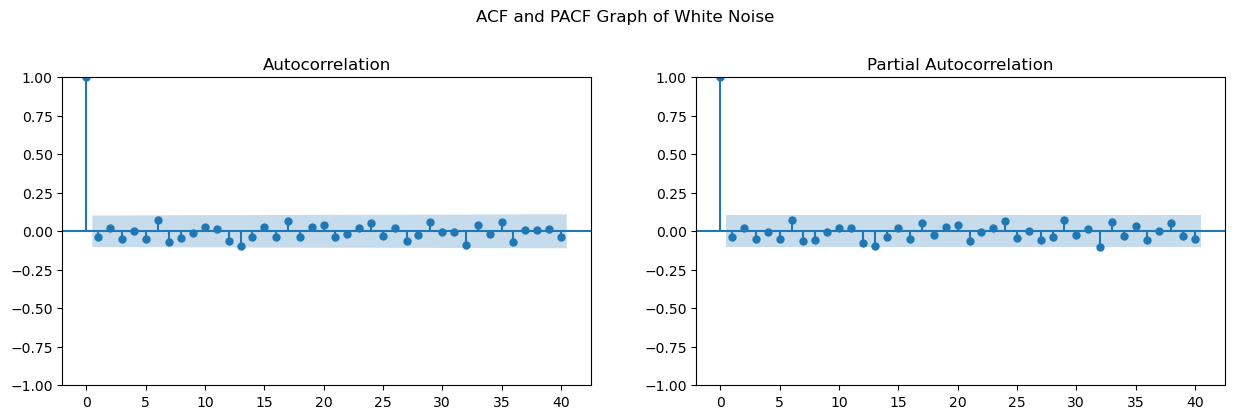

In [20]:
#### ACF와 PACF
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(x, lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(x, lags=40, ax=axes[1])
fig.suptitle('ACF and PACF Graph of White Noise', y = 1.05)
plt.show()

자기상관 및 편자기상관 없음 --> 정상성

## 비정상성 시계열(추세 존재)

In [21]:
# 추세 생성및 백색잡음에 추세 추가
trend = np.linspace(1,15,365) # 추세 생성
x_w_trend = x + trend # 백색 잡음 x에 추세 추가

#### 원계열 시도표(Time plot)

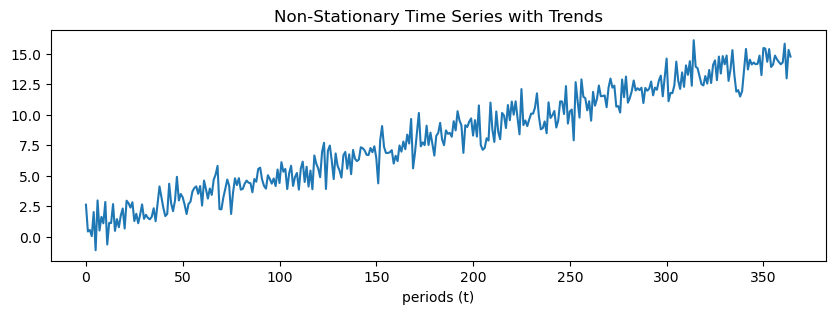

In [22]:
# 추세 존재 시계열의 시도표
plt.figure(figsize=(10,3))

plt.plot(np.arange(365), x_w_trend)
plt.title('Non-Stationary Time Series with Trends')
plt.xlabel('periods (t)')
plt.show()

#### Augmented Dickey Fuller Test 단위근 검정(ADF test)
##### Augmented Dickey Fuller Test 가설 검정
$H_0$ : 정상성이 있는 시계열이 아님(단위근)

$H_1$ : 정상성이 있는 시계열
##### 귀무 가설을 기각해야 정상성이 있는 시계열

In [23]:
# 비정상 시계열에 대한 단위근 검정 결과
result = adfuller(x_w_trend)
print('ADF stat : {:.4f}'.format(result[0]))
print('p_value : {:.4f}'.format(result[1]))
print('Critical Values : ')
for key, value in result[4].items():
    print('\t{} : {:.4f}'.format(key, value))

ADF stat : -0.7079
p_value : 0.8447
Critical Values : 
	1% : -3.4493
	5% : -2.8699
	10% : -2.5712


p_value가 0에 수렴하지 않고 0.8447 이므로 귀무가설 기각 실패 --> 정상성 만족 X

#### ACF와 PACF

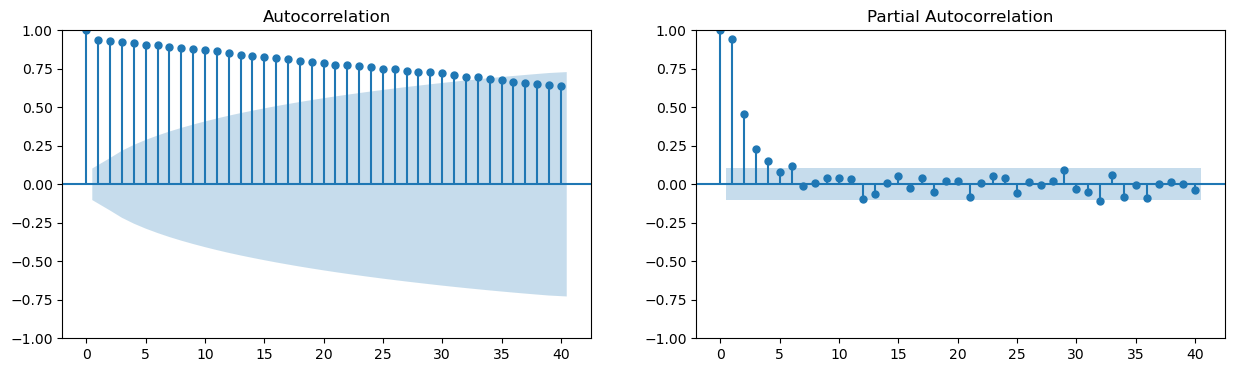

In [25]:
#### ACF와 PACF
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(x_w_trend, lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(x_w_trend, lags=40, ax=axes[1])
plt.show()

자기상관(Autocorrelation)은 시간이 흐를수록 줄어들고 있음 (파란 음영부분 안으로 들어옴) & 편자기상관(Paritial Autocorrelation)은 시차 5번째부터 파란 음영부분으로 들어왔음

ACF가 급격히 떨어져 음영에 들어올때 PACF에서 급격히 떨어져 음영까지 들어가는 구간이 있다면 해당부분은 AR 사용

#### ARiMA -- AR(05)

In [32]:
# statsmodels가 제공하는 ARIMA 사용
#order = ('AR(P)의 차수', '누적(I)의 차수', 'MA의 차수' )
arima_mod = ARIMA(x_w_trend, order=(5, 0, 0)) #AR order만 5, 따라서 AR(5) 모델임

In [28]:
result = arima_mod.fit()

In [29]:
# 실데이터 vs 모델 결과

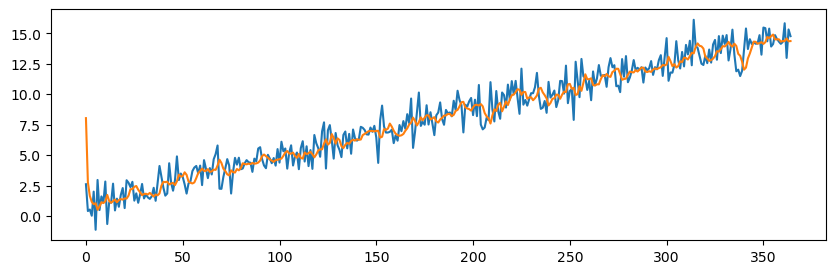

In [30]:
plt.figure(figsize=(10,3))

plt.plot(np.arange(365), x_w_trend)
plt.plot(np.arange(365), result.fittedvalues)
plt.show()

In [31]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -545.109
Date:                Sat, 17 Feb 2024   AIC                           1104.217
Time:                        16:40:46   BIC                           1131.516
Sample:                             0   HQIC                          1115.066
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0428      5.053      1.592      0.111      -1.861      17.947
ar.L1          0.1981      0.048      4.106      0.000       0.104       0.293
ar.L2          0.2489      0.052      4.796      0.0

- Log Likelihood는 클수록 AIC, BIC  값이 작을수록 좋은 모델
- Ljung-Box(Q) 통계량의 귀무가설 : "잔차(residual)는 백색잡음(white noise)" 
- Jarque-Bera(JB) 통계량의 귀무가설 : "잔차(residual)는 정규성을 만족"

잔차가 정규성을 띈다면, skew는 0 kurtosis는 3에 가까운 것이 특징

#### 모델 성능 평가

In [34]:
print('mean absolute error : {:.4f}'. format(result.mae))

mean absolute error : 0.8551


   - 낮을수록 좋음

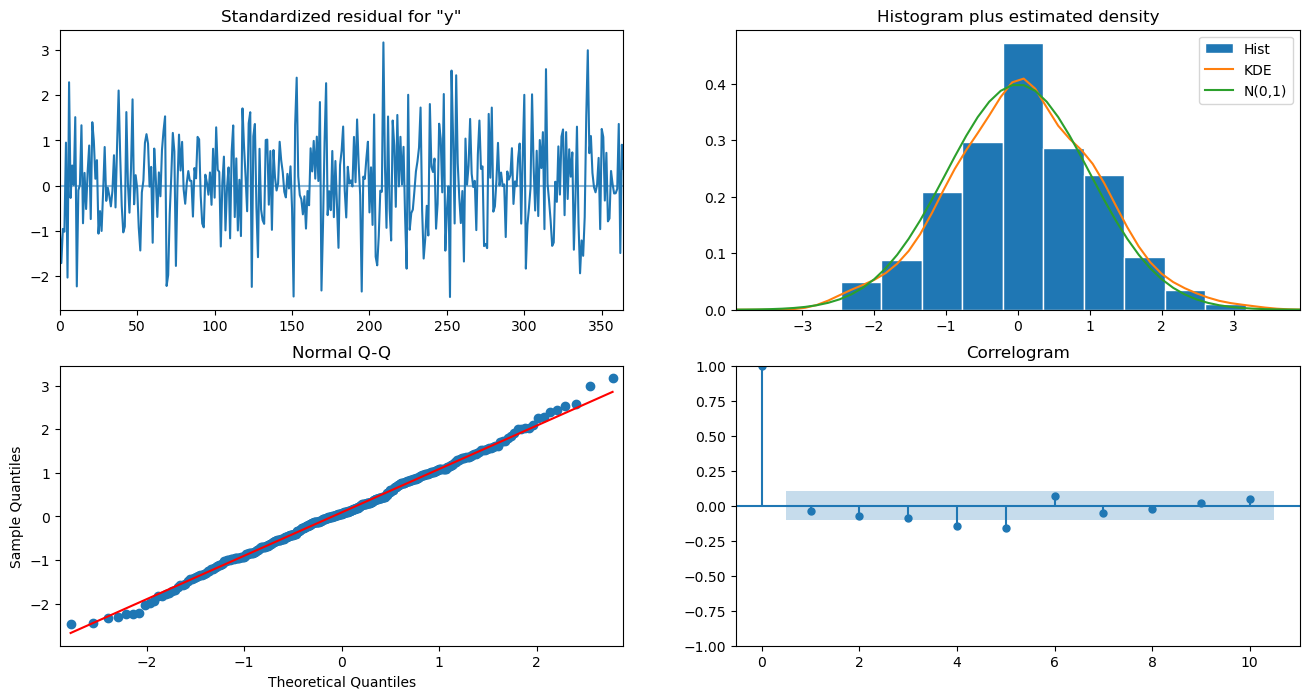

In [36]:
result.plot_diagnostics(figsize=(16,8))
plt.show()

#### ARIMA -- I(1)
 - 추세는 차분을 통해 제거할 수 있다.

In [37]:
# 차분만을 이용한 추세 제거 모델링
arima_mod2 = ARIMA(x_w_trend, order=(0, 1, 0))
result = arima_mod2.fit()

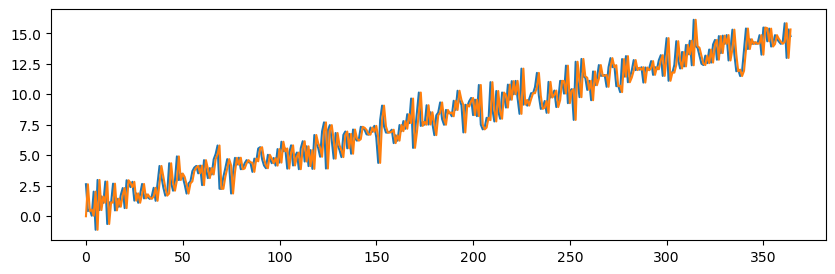

In [38]:
plt.figure(figsize=(10,3))

plt.plot(np.arange(365), x_w_trend)
plt.plot(np.arange(365), result.fittedvalues)
plt.show()

In [41]:
# 원계열 값 - 학습된 값
i_1 = np.sum(np.abs(x_w_trend - result.fittedvalues))
i_1

398.3766694444252

In [42]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -634.642
Date:                Sat, 17 Feb 2024   AIC                           1271.284
Time:                        17:00:36   BIC                           1275.181
Sample:                             0   HQIC                          1272.833
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.9139      0.130     14.755      0.000       1.660       2.168
Ljung-Box (L1) (Q):                 100.83   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.00   Pr

- Q 값이 매우커 귀무가설을 기각,
- 잔차가 매우크고 나서도 비정상 적인 부분을 갖고있음

#### 모델 성능 평가

In [44]:
print('mean absolute error : {:.4f}'. format(result.mae))

mean absolute error : 1.0914


- 예측력이 떨어짐

In [48]:
from sklearn.metrics import mean_absolute_error

In [50]:
mae = mean_absolute_error(x_w_trend, result.fittedvalues)
print('mean_absolute_error : {:.4f}'.format(mae))

mean_absolute_error : 1.0914


In [52]:
pm.arima.auto_arima(x_w_trend,
                   d=1,
                   start_p = 0, # AR 시작 차수
                   max_p = 5, # AR 최대 차수
                   start_q = 0, # MA 시작 차수
                   max_q = 5, # MA 최대차수
                   seasonal = False,
                   step=True,
                   trace=True
                   )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1273.072, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1157.411, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1271.284, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1125.228, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1101.074, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1092.347, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1071.004, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1075.303, Time=0.05 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0] intercept
Total fit time: 1.500 seconds


ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

AIC가 낮은것이 좋고 Log Likelihood는 큰것이 좋다

In [53]:
arima_mod3 = ARIMA(x_w_trend, order=(5,1,0))

In [54]:
result = arima_mod3.fit()

In [55]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -531.651
Date:                Sat, 17 Feb 2024   AIC                           1075.303
Time:                        17:15:41   BIC                           1098.686
Sample:                             0   HQIC                          1084.596
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8423      0.047    -17.886      0.000      -0.935      -0.750
ar.L2         -0.6425      0.069     -9.352      0.000      -0.777      -0.508
ar.L3         -0.5129      0.067     -7.630      0.0

- Log Likelihood, AIC, BIC 확인
- Ljung-Box(Q) 통계량의 귀무가설과 Jarque-Bera(JB) 통계량의 귀무가설이 기각되지 않는지 확인

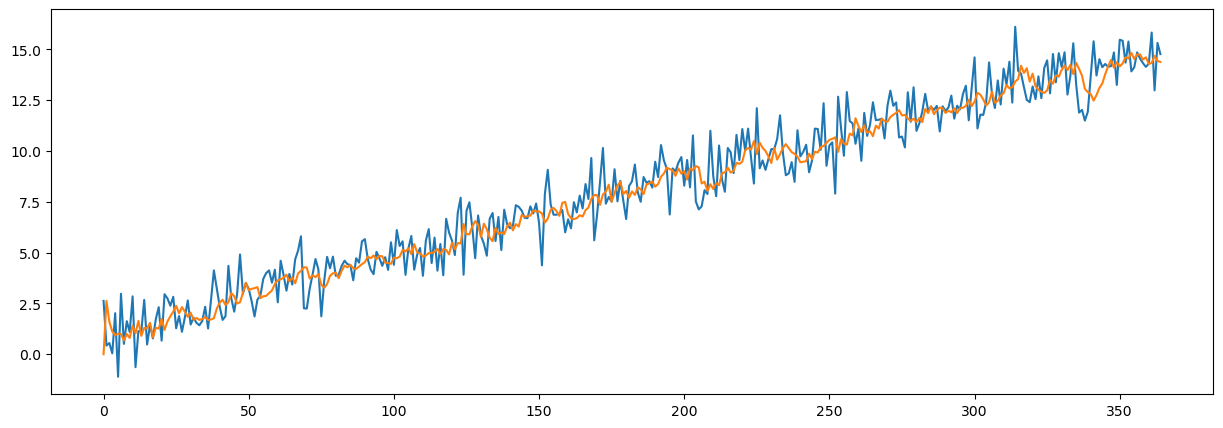

In [60]:
plt.figure(figsize=(15, 5))

plt.plot(np.arange(365), x_w_trend)
plt.plot(np.arange(365), result.fittedvalues)
plt.show()

### 시계열 성분 분해 (Time Series Decomposition)

In [280]:
#데이터 없으니 만듬.
#  white noise 만들기
np.random.seed(1)
w_n = np.random.randint(8500,10500,size=168)
# 추세 만들기
trend = np.linspace(0,10000,168)
# 계절성 만들기
season = [[0,0,0,10,900,1900,3110,1900,1400, -100, 0, -500],
           [0,0,0,0,20,2400,2600,1900,1700, -30, 0, 0],
           [0,0,0,10,400,1134,2302,3221,2901, -10, 0, 0],
           [0,0,0,20,900,1134,2202,3221,1901, 0, -70, 0],
         [0,0,0,0,0,2400,2002,3021,1001, 100, -10, 0],
         [0,0,0,0,1000,1100,2202,3021,1001, 800, 600, 100]]
np.random.seed(2)
rand_select = np.random.randint(0,6,size=14)

s_t= []

for i in range(14):
    k = 1.04**(i+1)
    for a in season[rand_select[i]]:
        s_t.append(a*k)
           
season_trend = np.array(s_t)

s_amount = w_n + trend + season_trend

# 데이터 프레임 만들기
season_df = pd.DataFrame(s_amount).astype(int)
date_df = pd.DataFrame(pd.date_range(start='2008-1-31', periods=168, freq='M'))

df = pd.merge(date_df, season_df, left_index=True, right_index=True, how = 'inner')
df.columns = ['time', 'sales_amount']

In [281]:
df= df.set_index('time', drop=True)
df

,sales_amount
time,
2008-01-31,9561
2008-02-29,8794
2008-03-31,10551
2008-04-30,9786
2008-05-31,11466
...,...
2021-08-31,25175
2021-09-30,20469
2021-10-31,19717


#### 시도표 (Time plot)

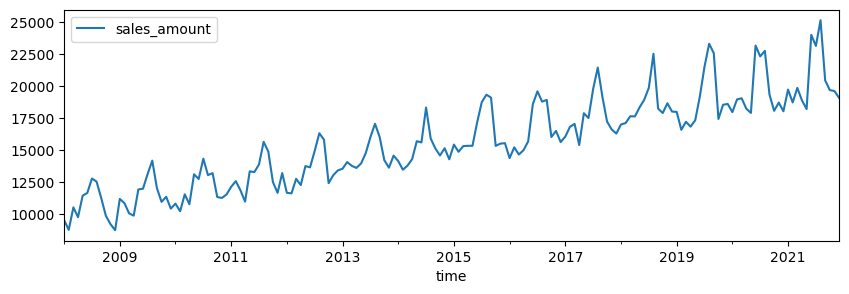

In [282]:
ts = df.copy()
# 시도표
ts.plot(figsize=(10,3))
plt.show()

시도표를 보며 생각해볼 점
1. 추세는 어떠한가? 우상향인가?, 우하상향인가?
2. 계절성은 어떠한가? 반복되는 패턴이 있는가?
3. 분산은 어떠한가? 시간의 흐름에 상관없이 일정한가? 아니면 증가하는가?

#### ACF와 PACF


C:\Users\User\anaconda3\envs\exam\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


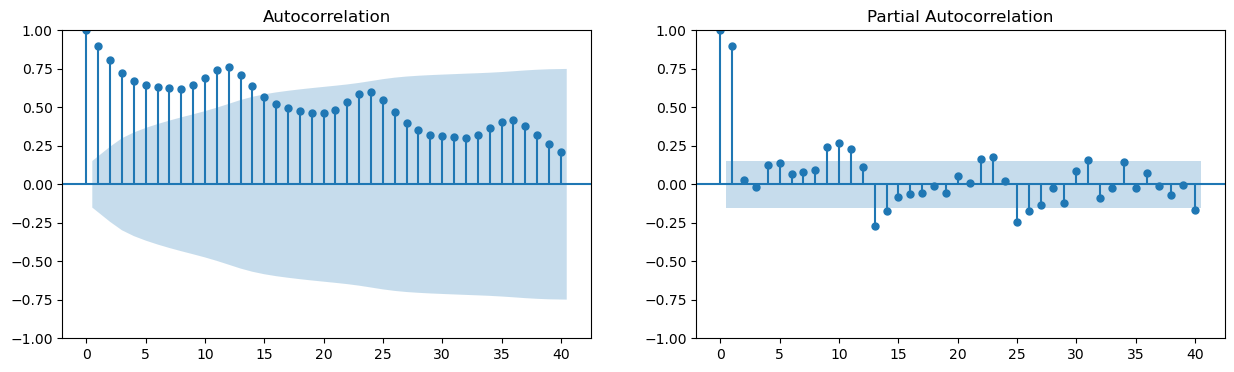

In [283]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(ts, lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=axes[1])
plt.show()

생각해볼점 : 자기상관의 패턴은 어떠한가? ㄷ또한 편자기상관의 패턴은 어떠한가?

### 계절성 분해 (seasonal_decompose)

In [284]:
# statsmodels이 제공하는 seasonal_decompose를 사용하자
decomp = seasonal_decompose(ts, model='additive', period=12) # additive 분해 방식 / model과 period 설정 (period = 12 - 1년주기의 계절)

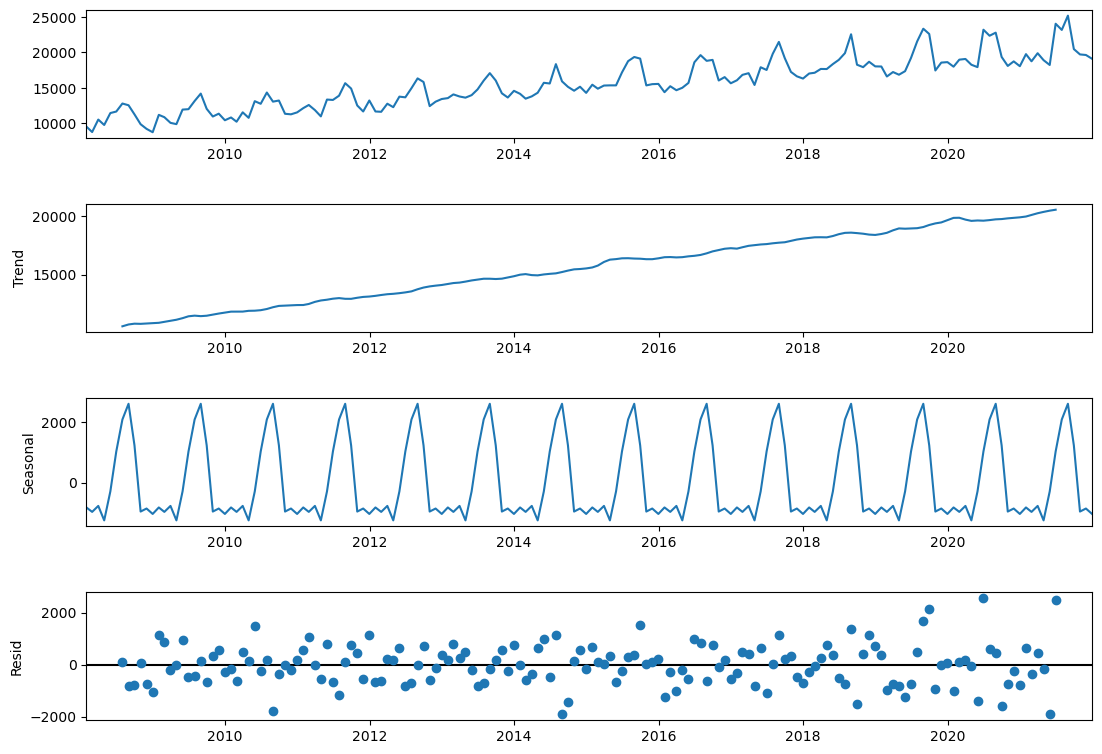

In [285]:
# 시계열 분해 그래프
fig = decomp.plot()
fig.set_size_inches((12,8))

분해 후 남는 잔차(Resid)를 살펴보자,시간에 흐름에 따라 동일한가? (homoskedastic)증가하는가/ 감소하는가(heteroskedastic)?

In [288]:
# seasonality에 따른 증감이 이 시간이 지남에따라 동일하게 올라간다면  additive
# 하지만 시간이 지남에 따라 커지므로 multiplicative 사용
decomp = seasonal_decompose(ts, model='multiplicative', period=12)

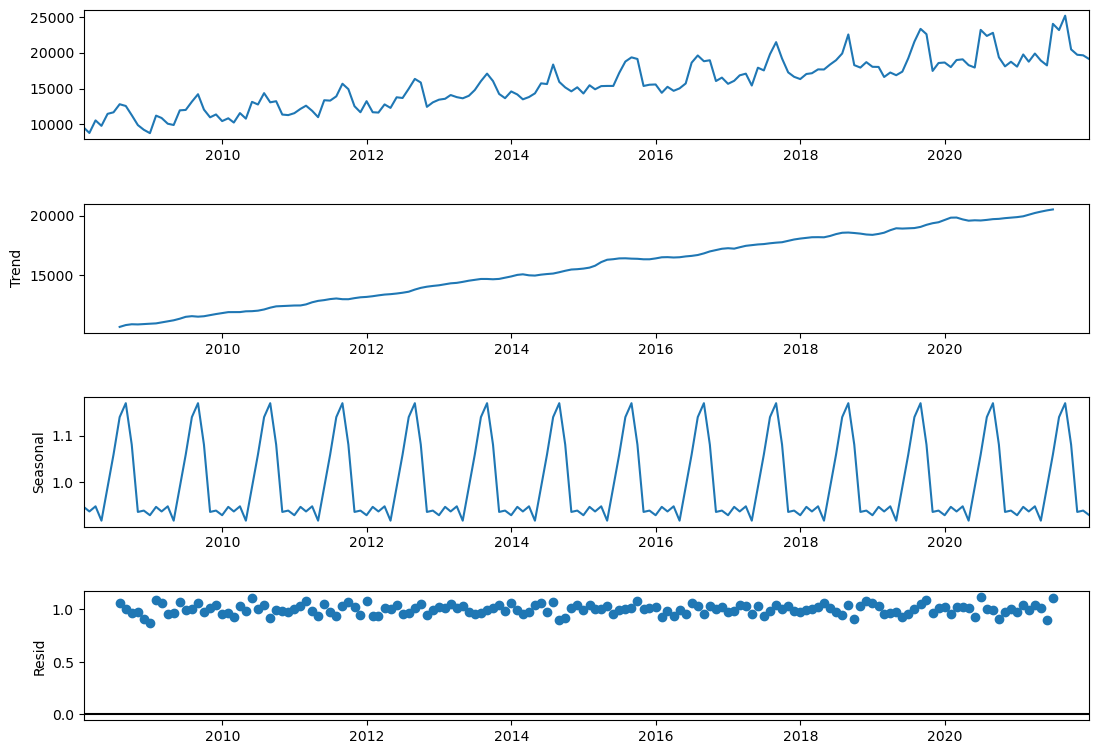

In [290]:
fig = decomp.plot()
fig.set_size_inches((12,8))

분해 후 남는 잔차(Resid)를 살펴보자. 시간에 흐름에 따라 동일한가? (homoskedastic)증가하는가/ 감소하는가(heteroskedastic)?

## SARIMAX : ARIMA + 계절성(S) = SARIMA

(참고: SARIMAX의 X는 Exogenous Variable을 의미하며, 우리는 외생변수를 사용하지 않을 것이기에 SARIMA 활용)

In [292]:
# seasonality ARIMA 모델링
# AR(1) + I(1) + MA(0)
#SAR(1) + I(1) 계절 주기는 12
s_mod = sm.tsa.statespace.SARIMAX(ts, order=(1,1,0), seasonal_order=(1,1,0,12))

C:\Users\User\anaconda3\envs\exam\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\exam\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [293]:
result = s_mod.fit()
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       sales_amount   No. Observations:                  168
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -1311.504
Date:                            Sat, 17 Feb 2024   AIC                           2629.009
Time:                                    19:10:57   BIC                           2638.139
Sample:                                01-31-2008   HQIC                          2632.717
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4638      0.062     -7.437      0.000      -0.586      -0.342
ar.S.L12      -0.4326      0.055   

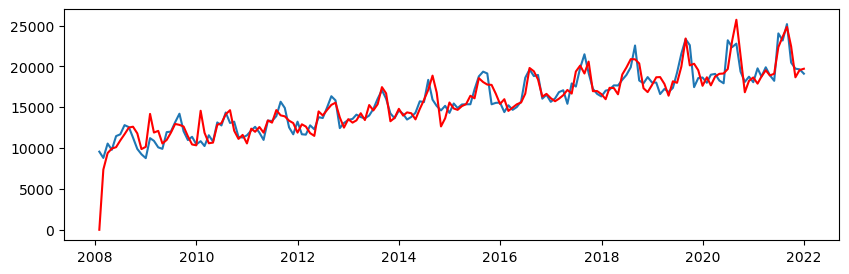

In [294]:
#예측 그래프
plt.figure(figsize=(10,3))
plt.plot(ts)
plt.plot(result.fittedvalues, color='r')
plt.show()

In [298]:
# auto arima
pm.arima.auto_arima(ts,
                   d=1,
                   start_p=0,
                   max_p=5,
                   start_q=0,
                   max_q=5,
                   D=1,
                   m=12, # m=7 : 일별, m=52 : 주별, m=12 : 월별
                   seasonal=True,
                   step=True,
                   trace=True
                   )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=2654.854, Time=0.21 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2694.456, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2629.009, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2661.529, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2626.824, Time=0.40 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=2620.371, Time=0.81 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=2618.371, Time=0.24 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2616.441, Time=0.16 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=2618.373, Time=0.39 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2652.960, Time=0.11 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=2608.064, Time=0.22 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=2657.674, Time=0.03 sec
 ARIMA(2,1,0)(1,1,1)[12]     

ARIMA(order=(5, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [303]:
s_mod = sm.tsa.statespace.SARIMAX(ts, order=(5, 1, 1), seasonal_order=(0, 1, 1, 12))

C:\Users\User\anaconda3\envs\exam\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\exam\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [304]:
result = s_mod.fit()
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       sales_amount   No. Observations:                  168
Model:             SARIMAX(5, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1280.774
Date:                            Sat, 17 Feb 2024   AIC                           2577.548
Time:                                    19:23:04   BIC                           2601.895
Sample:                                01-31-2008   HQIC                          2587.437
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0330      0.072      0.461      0.645      -0.108       0.174
ar.L2         -0.0040      0.082   

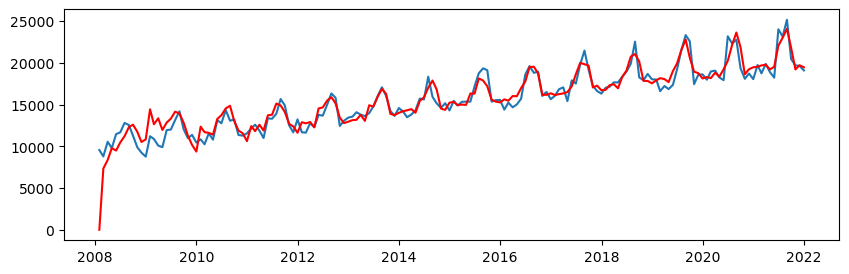

In [306]:
plt.figure(figsize=(10,3))
plt.plot(ts)
plt.plot(result.fittedvalues, color='r')
plt.show()

시계열데이터는 결과가 좋아도 시계열데이터의 가정이 만족되지 않는다면 일반화 시키기 어렵다.
